In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import cv2
import glob
import copy
%matplotlib inline
import skimage.filters
import skimage.exposure
import skimage.filters.rank
import skimage.morphology
import scipy.ndimage
import os
import matplotlib.image as img
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.filters import hessian
from skimage import morphology
import pywt

In [3]:
img = io.imread('21_training.jpg')

In [4]:
imgR = img[:,:,0]
imgG = img[:,:,1]
imgB = img[:,:,2]

Text(0.5, 1.0, 'Blue Channel')

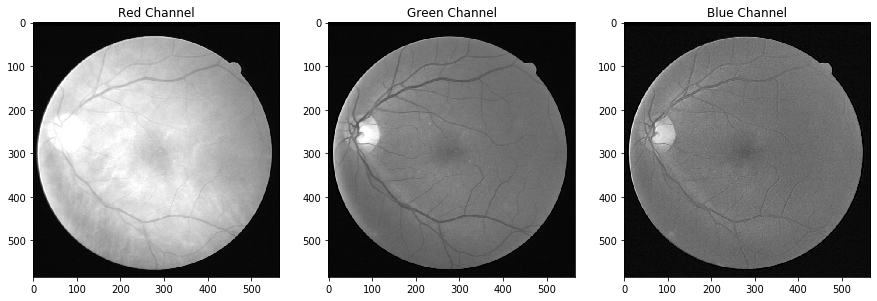

In [5]:
#plotting the different channels
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(imgR,cmap='gray')
plt.title('Red Channel')
fig.add_subplot(1, 3, 2)
plt.imshow(imgG,cmap='gray')
plt.title('Green Channel')
fig.add_subplot(1, 3, 3)
plt.imshow(imgB,cmap='gray')
plt.title('Blue Channel')

In [6]:
#histogram function, returns list with frequencies
def drawHistogram(img):
    his = np.zeros(256,)
    a = img.flatten()
    for i in a:
        his[i] = his[i]+1
    return his

(array([   72.,  7381.,   680.,   930.,  1706.,  8074., 10542., 23352.,
        19138., 19663.,  9521.,  2149.,  1107.,   212.,   173.,   141.,
          189.,   153.,   282.,   244.,   428.,   526.,   394.,   641.,
          488.,   803.,   599.,   994.,   718.,  1248.,  1413.,  1016.,
         1678.,  1247.,  2134.,  1631.,  2715.,  2020.,  3597.,  2742.,
         4957.,  5808.,  4786.,  7676.,  5740., 10443.,  7405., 12184.,
         8585., 13285., 13221.,  8637., 12282.,  7565., 10686.,  6436.,
         8715.,  5362.,  6863.,  3988.,  5276.,  4350.,  2462.,  3205.,
         1690.,  2171.,  1238.,  1435.,   874.,  1130.,   947.,   604.,
          805.,   441.,   624.,   369.,   494.,   304.,   389.,   239.,
          334.,   313.,   184.,   269.,   171.,   252.,   149.,   229.,
          133.,   184.,   150.,    88.,   145.,    86.,   136.,    69.,
          108.,    59.,    92.,   397.]),
 array([  0.  ,   2.55,   5.1 ,   7.65,  10.2 ,  12.75,  15.3 ,  17.85,
         20.4 ,  22.95

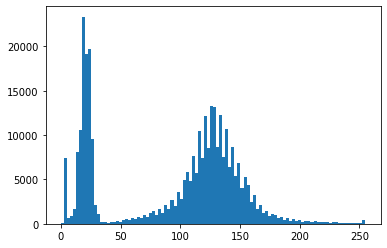

In [5]:
#clahe operation on the Green channel of image
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
clahe_img = clahe.apply(imgG)
plt.hist(clahe_img.flat, bins=100, range=(0,255))

Text(0.5, 1.0, 'Applying CLAHE')

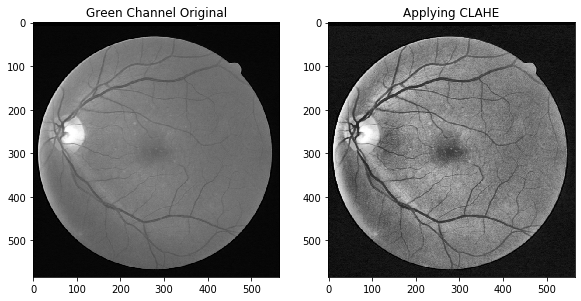

In [6]:
#checking effect of Clahe
fig = plt.figure(figsize=(15, 15))
fig.add_subplot(1, 3, 1)
plt.imshow(imgG,cmap='gray')
plt.title('Green Channel Original')
fig.add_subplot(1, 3, 2)
plt.imshow(clahe_img,cmap='gray')
plt.title('Applying CLAHE')

In [7]:
#morphological operations, Here we do opening then closing
cell_disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
Topen = cv2.morphologyEx(clahe_img,cv2.MORPH_OPEN,cell_disc)
Tclose = cv2.morphologyEx(Topen, cv2.MORPH_CLOSE, cell_disc)

#gtting the tophat image
TopHat = (clahe_img - Tclose)#.astype(np.uint8)

Text(0.5, 1.0, 'Green Channel Original')

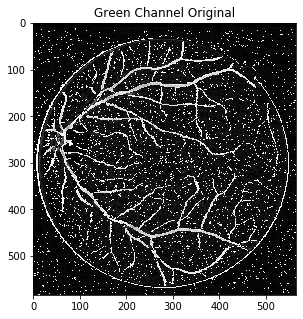

In [8]:
#checking the tophat image
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 1, 1)
plt.imshow(TopHat,cmap='gray')
plt.title('Green Channel Original')

Text(0.5, 1.0, 'Green Channel Original')

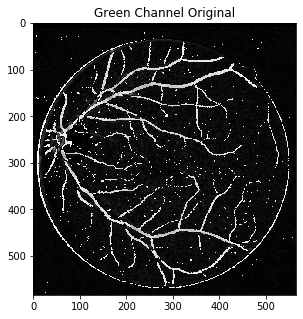

In [9]:
#More morphological operations, erosion then dilation
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
min_image = cv2.erode(TopHat, kernel)
min_image = cv2.dilate(min_image, kernel)
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 1, 1)
plt.imshow(min_image,cmap='gray')
plt.title('Green Channel Original')

In [10]:
#thresholding function
def threshold(img,k):
    ret = copy.deepcopy(img)
    ret[ret<k] = 0
    ret[ret>=k] = 255
    return ret

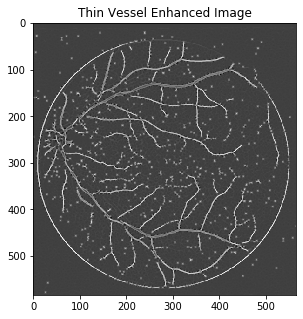

In [11]:
#hessian matrix and eigenvalues approach to get thin vessel enhanced image
HessThin = hessian_matrix(min_image, sigma=1.2, order='rc')
EignThin = hessian_matrix_eigvals(HessThin) [1]
fig = plt.figure(figsize=(15, 5))
plt.title("Thin Vessel Enhanced Image")
plt.imshow(1-EignThin, cmap=plt.cm.gray)

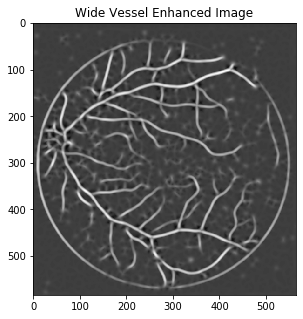

In [14]:
#hessian matrix and eigenvalues approach to get wide vessel enhanced image
HessWide = hessian_matrix(min_image, sigma=4, order='rc')
EignWide = hessian_matrix_eigvals(HessWide) [1]
fig = plt.figure(figsize=(15, 5))
plt.title("Wide Vessel Enhanced Image")
plt.imshow(1-EignWide, cmap='gray')

In [15]:
#global otsu thresholding function
def GlobalOtsu(img):
    foreground = img[img>=0]
    background = img[img<0]
    
    final_var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))
    if(np.isnan(final_var)):
        final_var = -1
        
    final_thresh = 0
    for i in np.linspace(np.min(img), np.max(img), num=255):
        foreground = img[img>=i]
        background = img[img<i]
        var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))
        
        if(np.isnan(var)):
            var = -1
            
        if(var!=-1 and (var<final_var or final_var ==-1)):
            final_var = var
            final_thresh = i
    return threshold(img,final_thresh)

In [16]:
#Area based thresholding/cleaning. Done as postprocessing step
def AreaThreshold(img, area = 5):
    nlabels,labels,stats,centroid = cv2.connectedComponentsWithStats(np.uint8(img), 4, cv2.CV_32S)

    output = np.copy(img)
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if stats[labels[i][j], cv2.CC_STAT_AREA] < area:
                output[i][j] = 0
                
    return output

In [17]:
#Local otsu thresholding
from skimage.filters import threshold_otsu, rank
from skimage.morphology import disk

def LocalOtsu1(img,radius = 5):
    selem = disk(radius)
    local_otsu = rank.otsu(img, selem)
    output = np.copy(img)
    output[output < local_otsu] = 0
    output[output >= local_otsu] = 255
    
    return output

In [18]:
#local Otsu thresholding function as per paper with offset included
def LocalOtsu2(img,radius = 15):
    selem = disk(radius)
    local_otsu = rank.otsu(img, selem)
    output = np.copy(img)
    rng = local_otsu.max() - local_otsu.min()
    mid = rng/2 + local_otsu.min()
    local_otsu[local_otsu<mid] = mid
    output[output < local_otsu] = 0
    
    return output

In [25]:
#using wavelet method for image fusion
def image_fusion(img1,img2):
    w1 = pywt.wavedec2(img1, 'db1')
    w2 = pywt.wavedec2(img2, 'db1')
    elem = (w1[0]+w2[0])/2
    fw = [elem]
    
    for i in range(len(w1)-1):
        x,y,z = (w1[i+1][0] + w2[i+1][0])/2, (w1[i+1][1] + w2[i+1][1])/2, (w1[i+1][2] + w2[i+1][2])/2
        fw.append((x,y,z))

    output = pywt.waverec2(fw, 'db1')
    
#     Normalisation, May or May not be required
    amin = np.min(output)
    amax = np.max(output)
    output = 255* ((output - amin)/(amax-amin))
    
    output = cv2.resize(output,img1.T.shape)
    return output

In [20]:
#Global otsu thresholding
val1 = GlobalOtsu(1-EignWide)

Text(0.5, 1.0, 'GlobalThresholdedThickVessel')

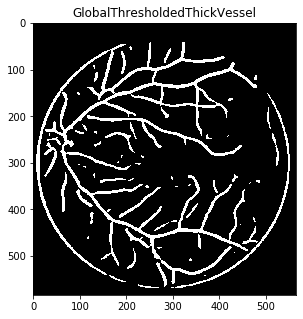

In [21]:
#Global otsu thresholded image
fig = plt.figure(figsize=(5, 5))
plt.imshow(val1,cmap='gray')
plt.title("GlobalThresholdedThickVessel")

In [22]:
#normalising the images for further processing
thinN = cv2.normalize(1-EignThin,  None, 0, 255, cv2.NORM_MINMAX)
val1 = cv2.normalize(val1,  None, 0, 70, cv2.NORM_MINMAX)

Text(0.5, 1.0, 'Thin vessels enhanced')

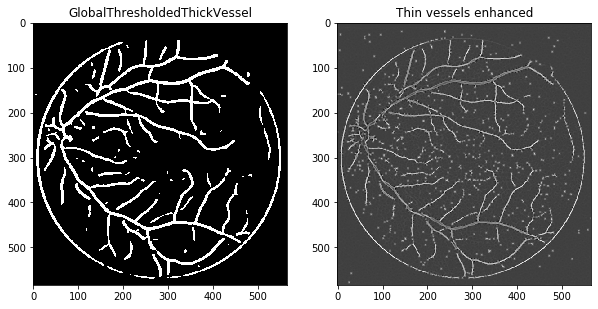

In [23]:
#Two images that have to be fused
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(val1,cmap='gray')
plt.title('GlobalThresholdedThickVessel')
fig.add_subplot(1, 2, 2)
plt.imshow(thinN,cmap='gray')
plt.title('Thin vessels enhanced')

In [26]:
#fusing the images
test1 = image_fusion(val1,thinN)

Text(0.5, 1.0, 'Image Fusion')

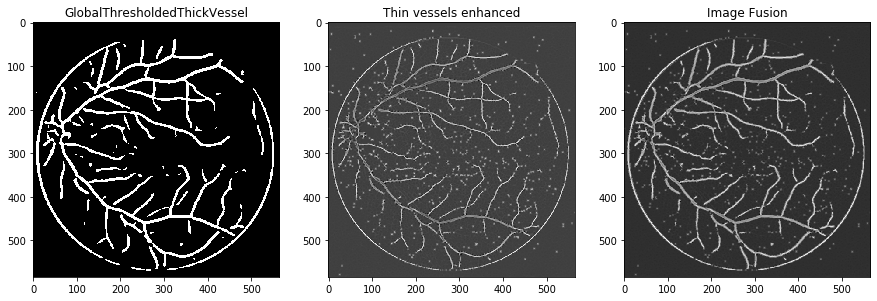

In [27]:
#comparing the fused image with originals
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(1, 3, 1)
plt.imshow(val1,cmap='gray')
plt.title('GlobalThresholdedThickVessel')
fig.add_subplot(1, 3, 2)
plt.imshow(thinN,cmap='gray')
plt.title('Thin vessels enhanced')
fig.add_subplot(1, 3, 3)
plt.imshow(test1,cmap='gray')
plt.title("Image Fusion")

Text(0.5, 1.0, 'Local Otsu Thresholding')

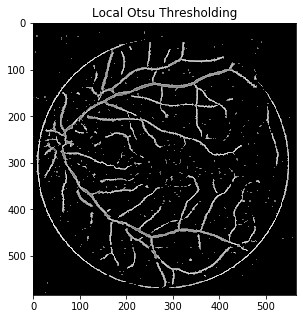

In [28]:
#local otsu thresholding on the fused image
lOtsu = LocalOtsu2(test1.astype('uint8'))
fig = plt.figure(figsize=(5, 5))
plt.imshow(lOtsu,cmap='gray')
plt.title("Local Otsu Thresholding")

Text(0.5, 1.0, 'Pixel/Area based Thresholding')

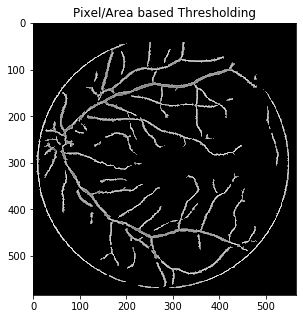

In [29]:
#area thresholding to remove non vessel regions
final = AreaThreshold(lOtsu,50)
fig = plt.figure(figsize=(5, 5))
plt.imshow(final,cmap='gray')
plt.title("Pixel/Area based Thresholding")

Text(0.5, 1.0, 'Final Output')

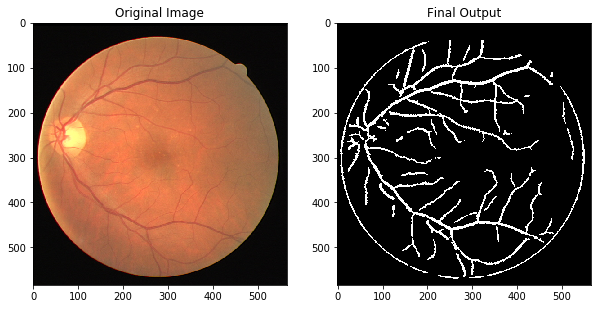

In [30]:
#binarizing final output and visualising it

final[final!=0] = 255

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
fig.add_subplot(1, 2, 2)
plt.imshow(final,cmap='gray')
plt.title("Final Output")

In [35]:
povodne = io.imread('21_povodne.jpg')

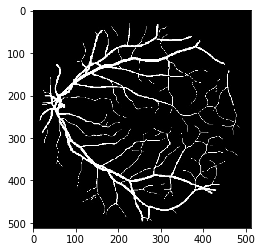

In [38]:
plt.imshow(povodne, cmap="gray")

Text(0.5, 1.0, 'Final Output')

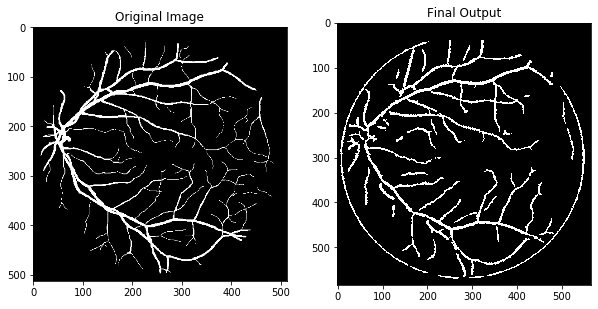

In [39]:
final[final!=0] = 255

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(povodne, cmap="gray")
plt.title('pôvodný obr')
fig.add_subplot(1, 2, 2)
plt.imshow(final,cmap='gray')
plt.title("môj obr")